In [135]:
# Libraries.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

plt.rcParams['figure.figsize'] = 20, 10

In [136]:
# Data.

Dataset = pd.read_csv("data_realKnownCause_ambient_temperature_system_failure.csv", sep = ',', low_memory = False)
Dataset = Dataset.rename(columns = {"timestamp":"Date", "value":"Temperature"})
Dataset['Temperature'] = pd.to_numeric(Dataset['Temperature'])
Dataset['Date'] = pd.to_datetime(Dataset['Date'])

# Fahrenheit to Celsius 
Dataset['Temperature'] = (Dataset['Temperature'] - 32) * 5/9

# Features list

# date -> each row for each hour in a day.
# temperature -> temperature float for each date.

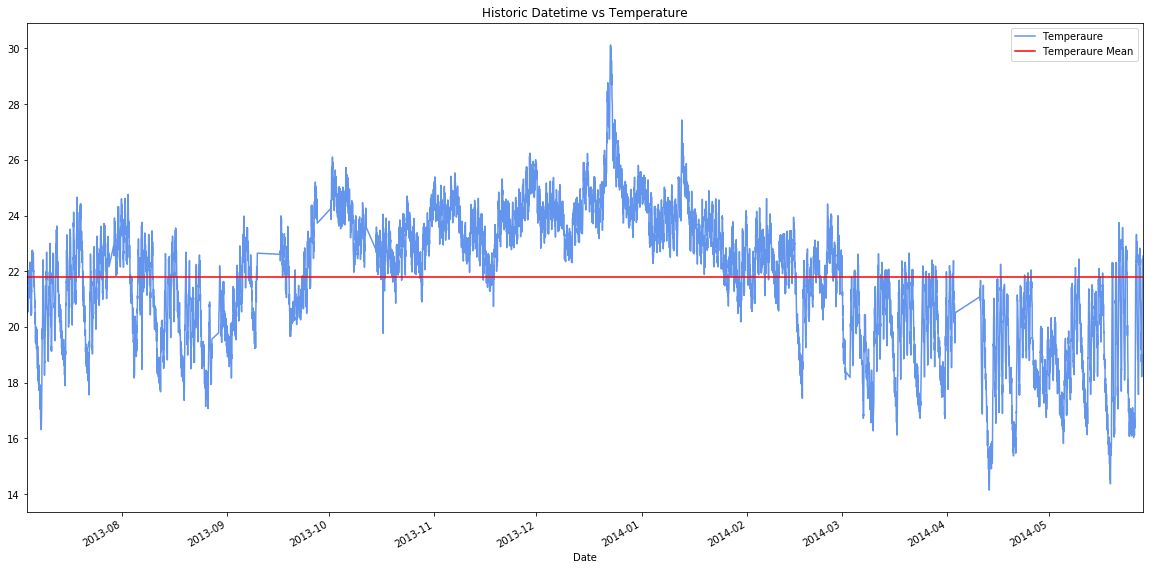

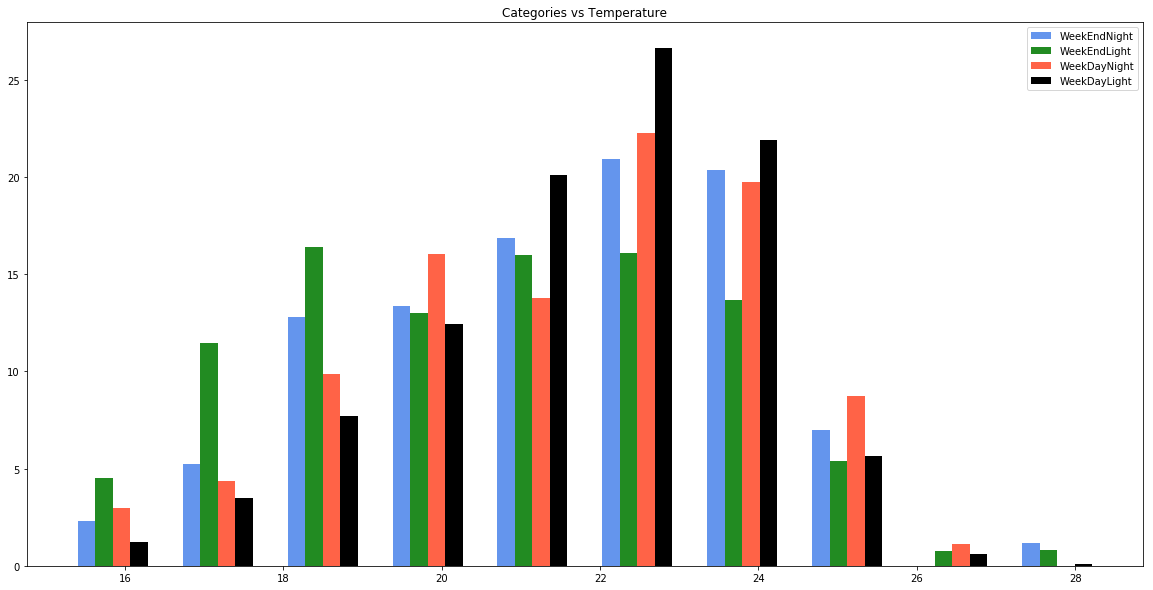

In [140]:
# Preprocessing.

class Utils:

    def GetDistanceByPoint(ClusterDataset, ClusterModel):
        ClusterDistance = pd.Series()
        for Cluster in range(0, len(ClusterDataset)):
            FirstPoint = np.array(ClusterDataset.loc[Cluster])
            SecondPoint = ClusterModel.cluster_centers_[ClusterModel.labels_[Cluster] - 1]
            ClusterDistance.set_value(Cluster, np.linalg.norm(FirstPoint - SecondPoint))
        return ClusterDistance

class DateFeatures:   
    
    Dataset['Hours'] = Dataset['Date'].dt.hour
    Dataset['DayLight'] = ((Dataset['Hours'] > 7 & (Dataset['Hours'] < 22))).astype(int)
    Dataset['DayOfTheWeek'] = Dataset['Date'].dt.dayofweek
    Dataset['WeekDay'] = (Dataset['DayOfTheWeek'] < 5).astype(int)
    Dataset['TimeEpoch'] = (Dataset['Date'].astype(np.int64)/100000000000).astype(np.int64)

class PreprocessingVisualization(DateFeatures):
    
    def HistoricDatePlot():
        Dataset.plot(x = 'Date', y = 'Temperature', color = 'cornflowerblue', label = 'Temperaure')
        plt.axhline(np.mean(Dataset['Temperature']), color = 'red', label = 'Temperaure Mean')
        
    def CategoriesBarPlot():
        
        Dataset['Categories'] = Dataset['WeekDay']*2 + Dataset['DayLight']

        WeekEndNight = Dataset.loc[Dataset['Categories'] == 0, 'Temperature']
        WeekEndLight = Dataset.loc[Dataset['Categories'] == 1, 'Temperature']
        WeekDayNight = Dataset.loc[Dataset['Categories'] == 2, 'Temperature']
        WeekDayLight = Dataset.loc[Dataset['Categories'] == 3, 'Temperature']

        Fig, ax = plt.subplots()
        
        WeekEndNightHeights, WeekEndNightBins = np.histogram(WeekEndNight)
        WeekEndLightHeights, WeekEndLightBins = np.histogram(WeekEndLight, bins = WeekEndNightBins)
        WeekDayNightHeights, WeekDayNightBins = np.histogram(WeekDayNight, bins = WeekEndNightBins)
        WeekDayLightHeights, WeekDayLightBins = np.histogram(WeekDayLight, bins = WeekEndNightBins)
        
        Width = (WeekEndNightBins[1] - WeekEndNightBins[0])/6
        
        ax.bar(WeekEndNightBins[:-1], (WeekEndNightHeights*100/WeekEndNight.count()), width = Width, 
               facecolor = 'cornflowerblue', label = 'WeekEndNight')
        ax.bar(WeekEndLightBins[:-1] + Width, (WeekEndLightHeights*100/WeekEndLight.count()), width = Width, 
               facecolor = 'forestgreen', label = 'WeekEndLight')
        ax.bar(WeekDayNightBins[:-1] + Width*2, (WeekDayNightHeights*100/WeekDayNight.count()), width = Width, 
               facecolor = 'tomato', label = 'WeekDayNight')
        ax.bar(WeekDayLightBins[:-1] + Width*3, (WeekDayLightHeights*100/WeekDayLight.count()), width = Width, 
               facecolor = 'black', label = 'WeekDayLight')

PreprocessingVisualization.HistoricDatePlot()
plt.title('Historic Datetime vs Temperature')
plt.legend()
plt.show()

PreprocessingVisualization.CategoriesBarPlot()
plt.title('Categories vs Temperature')
plt.legend()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


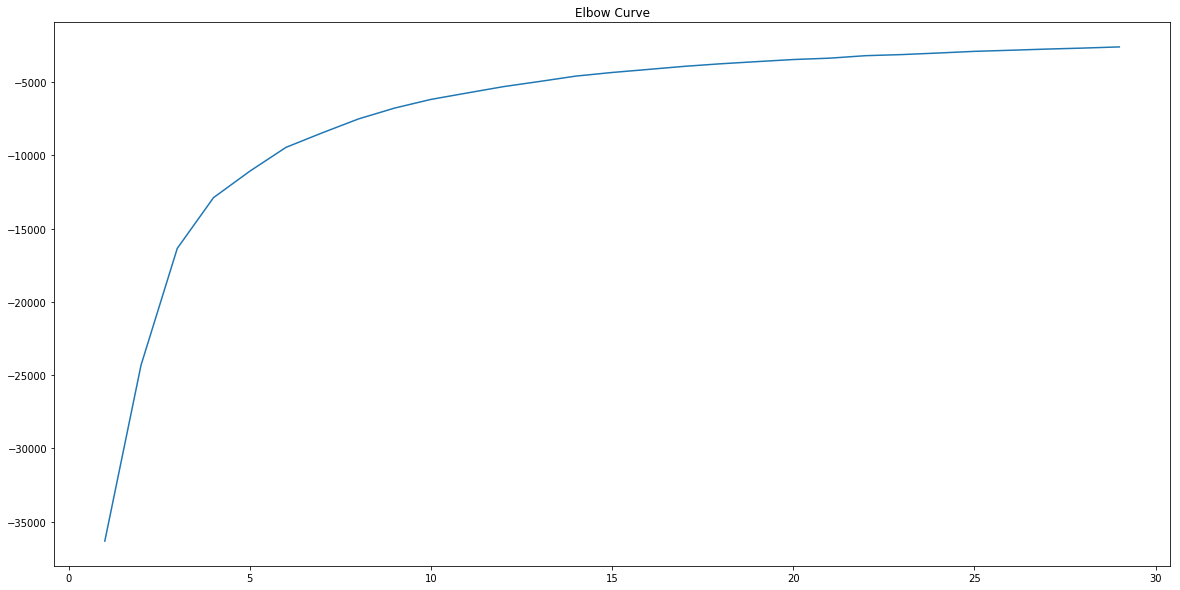

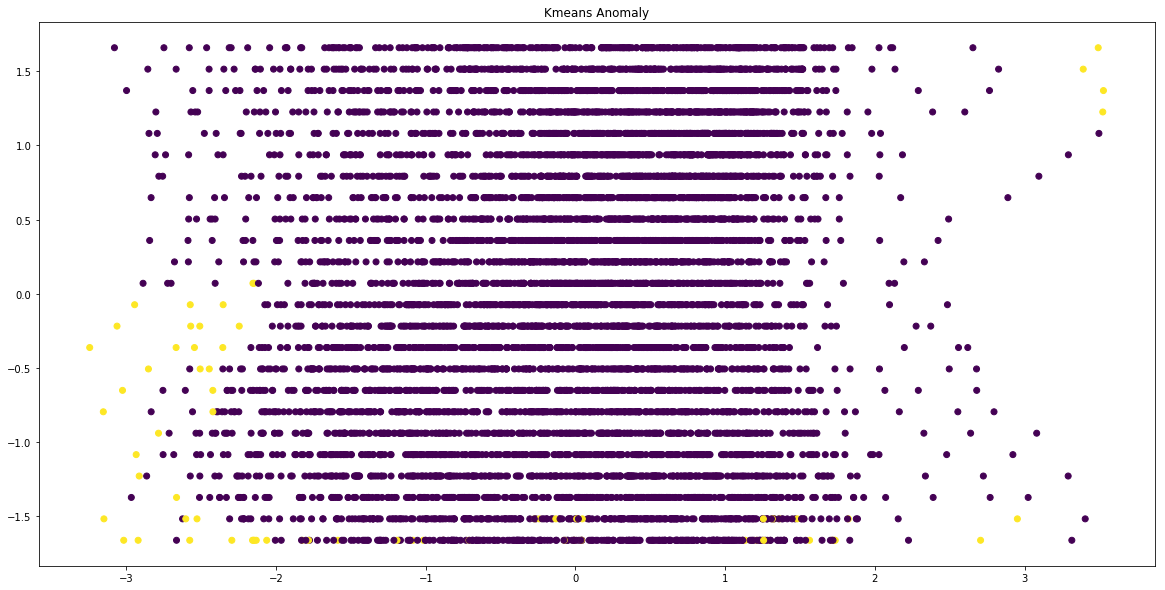

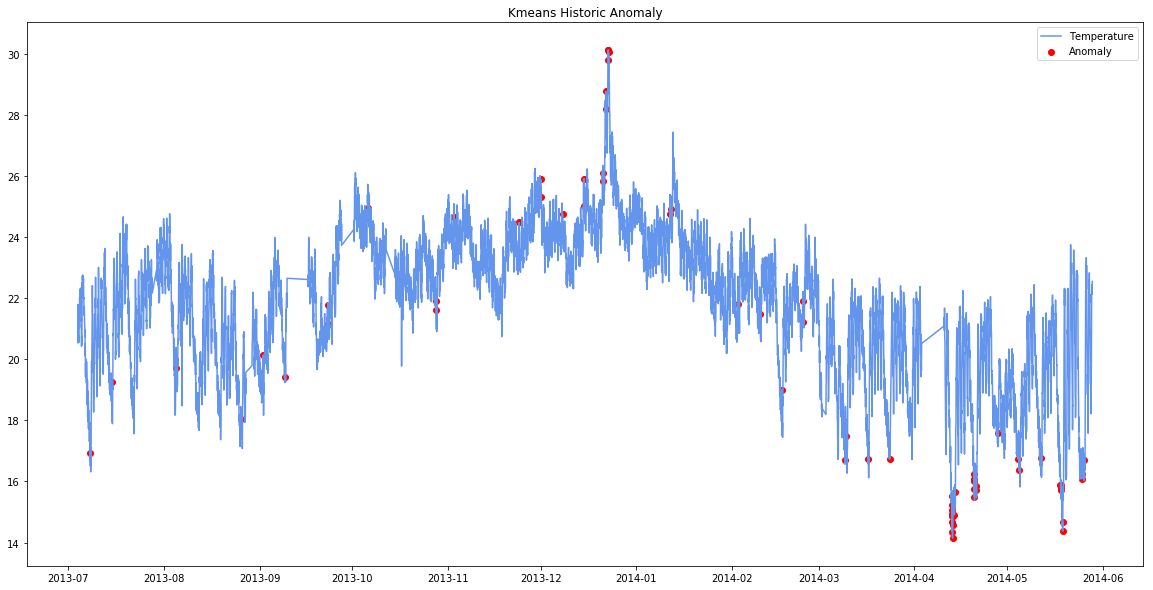

In [141]:
# KMeans Model.

class ClusterPreprocessing(DateFeatures):
    
    DatasetGrouped = Dataset[['Temperature', 'Hours', 'DayLight', 'DayOfTheWeek', 'WeekDay']].astype(float)
    
    def GroupingTheData():
        pca = PCA(n_components = 2)
        DatasetGrouped = pca.fit_transform(ClusterPreprocessing.DatasetGrouped)
    
    def ScalingTheData():
        StandardScaler = preprocessing.StandardScaler()
        DataScaled = StandardScaler.fit_transform(ClusterPreprocessing.DatasetGrouped)
        DataScaled = pd.DataFrame(DataScaled)
        return DataScaled
    
    def ClusterElbowCurve():
        Clusters = range(1, 30)
        KmeansClustering = [KMeans(n_clusters = Cluster).fit(ClusterPreprocessing.ScalingTheData()) for Cluster in Clusters]
        KmeansScores = [KmeansClustering[Cluster].score(
            ClusterPreprocessing.ScalingTheData()) for Cluster in range(len(KmeansClustering))]
        Fig, ax = plt.subplots()
        ax.plot(Clusters, KmeansScores)
    
    def FindingTheOptimalEpsValue():        
        Neighbors = NearestNeighbors(n_neighbors = 2)
        NeighborsFitted = Neighbors.fit(ClusterPreprocessing.ScalingTheData())
        DistancesBetweenNeighbors, Indices = NeighborsFitted.kneighbors(ClusterPreprocessing.ScalingTheData())
        DistancesBetweenNeighbors = np.sort(DistancesBetweenNeighbors, axis = 0)
        DistancesBetweenNeighbors = DistancesBetweenNeighbors[:, 1]
        plt.plot(DistancesBetweenNeighbors)

class ClusteringModels():
    
    Cluster = 14
    OutliersFraction = 0.01
    
    Kmeans = KMeans(n_clusters = Cluster).fit(ClusterPreprocessing.ScalingTheData())
    
    KmeansDistance = Utils.GetDistanceByPoint(ClusterPreprocessing.ScalingTheData(), Kmeans)
    NumberOfOutliers = int(OutliersFraction*len(KmeansDistance))
    Threshold = KmeansDistance.nlargest(NumberOfOutliers).min()

    Dataset['AnomalyKMeans'] = (KmeansDistance >= Threshold).astype(int)
    Dataset['Cluster'] = Kmeans.predict(ClusterPreprocessing.ScalingTheData())
    Dataset['PrincipalFeature1'] = ClusterPreprocessing.ScalingTheData()[0]
    Dataset['PrincipalFeature2'] = ClusterPreprocessing.ScalingTheData()[1]
    Dataset['Cluster'].value_counts()
    
    def ScatteringKMeansModel():
        Fig, ax = plt.subplots()
        ax.scatter(Dataset['PrincipalFeature1'], Dataset['PrincipalFeature2'], 
                   c = Dataset["Cluster"])
    
    def ScatteringKMeansModelAnomaly():
        Fig, ax = plt.subplots()
        ax.scatter(Dataset['PrincipalFeature1'], Dataset['PrincipalFeature2'],
                   c= Dataset["AnomalyKMeans"])
    
    def KmeansModelDatePlot():
        FigKMeans, ax = plt.subplots()
        AnomalyCondition = Dataset.loc[Dataset['AnomalyKMeans'] == 1, ['Date', 'Temperature']] 
        ax.plot(Dataset['Date'], Dataset['Temperature'], color = 'cornflowerblue', label = 'Temperature')
        ax.scatter(AnomalyCondition['Date'], AnomalyCondition['Temperature'], color = 'red', label = 'Anomaly')
        
ClusterPreprocessing.ClusterElbowCurve()
plt.title('Elbow Curve')
plt.show()

#ClusteringModels.ScatteringKMeansModel()
#plt.title('Kmeans 14 clusters')
#plt.show()

ClusteringModels.ScatteringKMeansModelAnomaly()
plt.title('Kmeans Anomaly')
plt.show()

ClusteringModels.KmeansModelDatePlot()
plt.title('Kmeans Historic Anomaly')
plt.legend()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\ProgramData\Anaconda3\

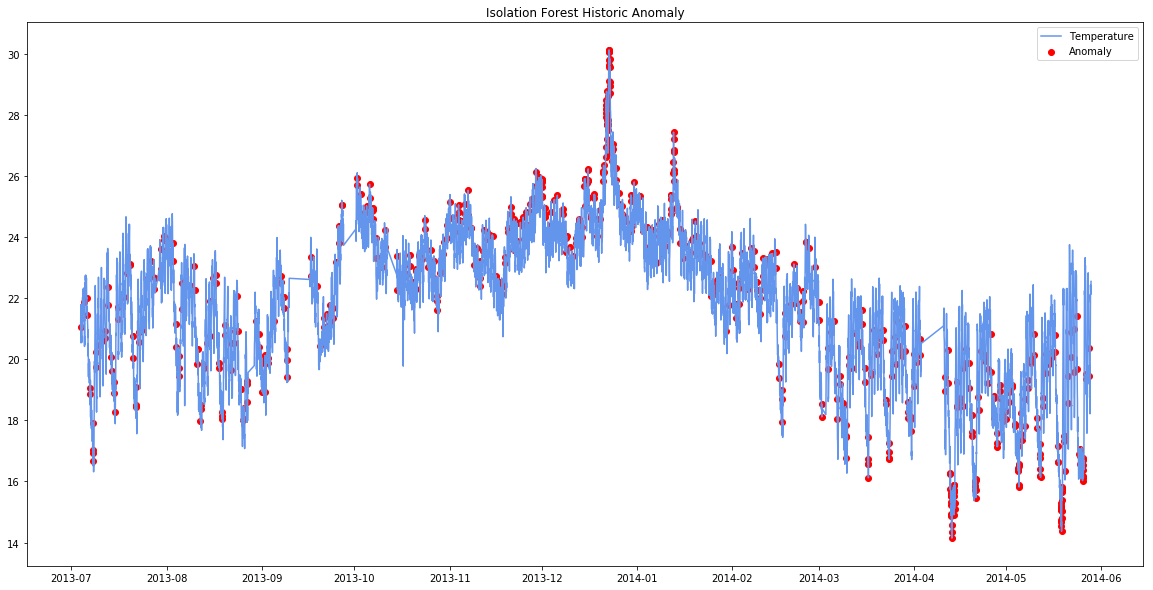

In [142]:
# Isolation Forest Model.

class IsolationForestModel():

    DataIsolationForest = Dataset[['Temperature', 'Hours', 'DayLight', 'DayOfTheWeek', 'WeekDay']]
    
    StandardScaler = preprocessing.StandardScaler()
    DataIsolationForestScaled = StandardScaler.fit_transform(DataIsolationForest)
    DataIsolationForest = pd.DataFrame(DataIsolationForestScaled)
    
    Model = IsolationForest()
    Model.fit(DataIsolationForest)
    
    DataIsolationForest['AnomalyIsolationForest'] = pd.Series(Model.predict(DataIsolationForest))
    DataIsolationForest['AnomalyIsolationForest'] = DataIsolationForest['AnomalyIsolationForest'].map( {1: 0, -1: 1})
    
    AnomalyCondition = Dataset.loc[DataIsolationForest['AnomalyIsolationForest'] == 1, ['Date', 'Temperature']] 
    
    def IsolationForestDatePlot():
        FigIsolationForest, ax = plt.subplots() 
        ax.plot(Dataset['Date'], Dataset['Temperature'], color = 'cornflowerblue', label = 'Temperature')
        ax.scatter(IsolationForestModel.AnomalyCondition['Date'], IsolationForestModel.AnomalyCondition['Temperature'], 
                   color = 'red', label = 'Anomaly')

IsolationForestModel.IsolationForestDatePlot()
plt.title('Isolation Forest Historic Anomaly')
plt.legend()
plt.show()

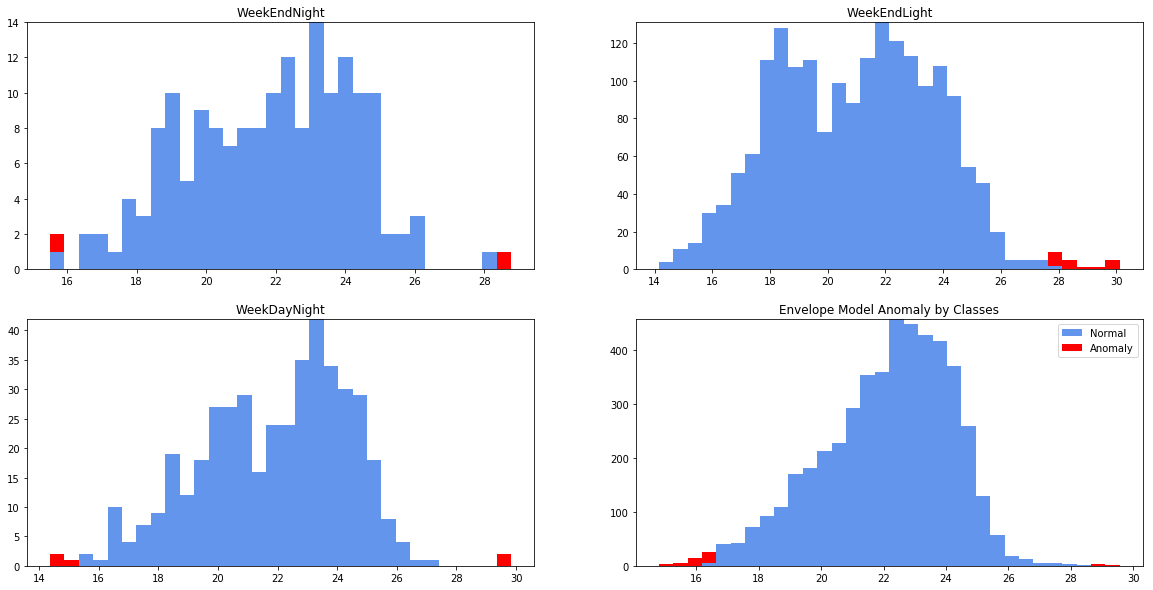

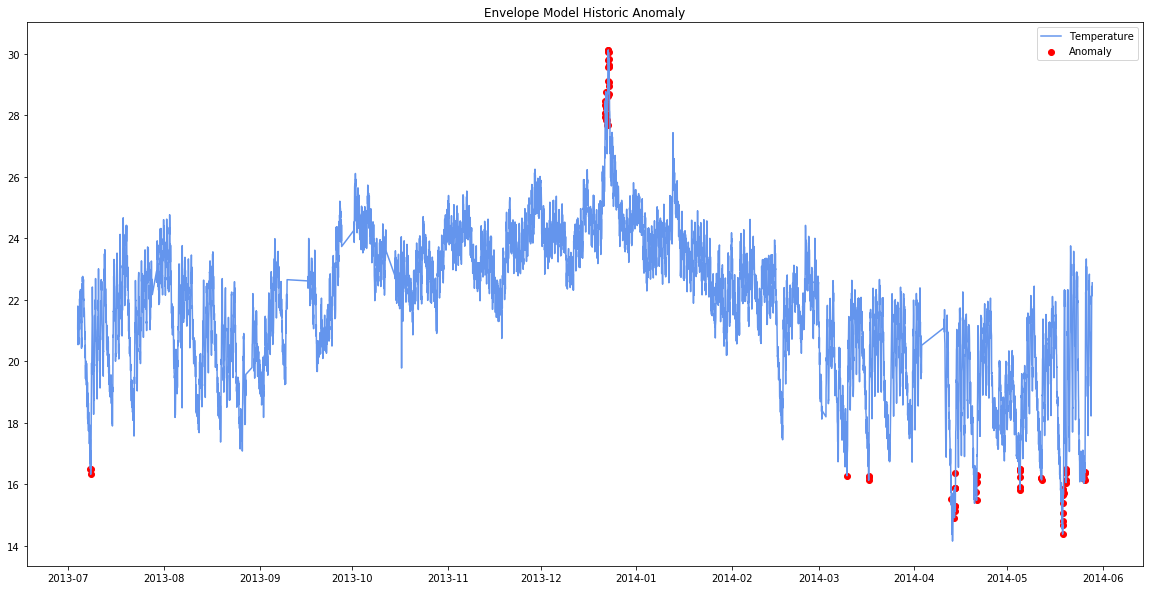

In [143]:
# Categories + Gaussian Model.

class CategoriesGaussianPreprocessing():

    FirstClass = Dataset.loc[Dataset['Categories'] == 0, 'Temperature']
    SecondClass = Dataset.loc[Dataset['Categories'] == 1, 'Temperature']
    ThirdClass = Dataset.loc[Dataset['Categories'] == 2, 'Temperature']
    FourthClass = Dataset.loc[Dataset['Categories'] == 3, 'Temperature']
    
class EnvelopeModel():
    
    Envelope =  EllipticEnvelope(contamination = ClusteringModels.OutliersFraction) 
    
    X_trainFirstClass = CategoriesGaussianPreprocessing.FirstClass.values.reshape(-1,1)
    Envelope.fit(X_trainFirstClass)
    CategoriesGaussianPreprocessing.FirstClass = pd.DataFrame(CategoriesGaussianPreprocessing.FirstClass)
    CategoriesGaussianPreprocessing.FirstClass['Deviation'] = Envelope.decision_function(X_trainFirstClass)
    CategoriesGaussianPreprocessing.FirstClass['Anomaly'] = Envelope.predict(X_trainFirstClass)

    X_trainSecondClass = CategoriesGaussianPreprocessing.SecondClass.values.reshape(-1,1)
    Envelope.fit(X_trainSecondClass)
    CategoriesGaussianPreprocessing.SecondClass = pd.DataFrame(CategoriesGaussianPreprocessing.SecondClass)
    CategoriesGaussianPreprocessing.SecondClass['Deviation'] = Envelope.decision_function(X_trainSecondClass)
    CategoriesGaussianPreprocessing.SecondClass['Anomaly'] = Envelope.predict(X_trainSecondClass)

    X_trainThirdClass = CategoriesGaussianPreprocessing.ThirdClass.values.reshape(-1,1)
    Envelope.fit(X_trainThirdClass)
    CategoriesGaussianPreprocessing.ThirdClass = pd.DataFrame(CategoriesGaussianPreprocessing.ThirdClass)
    CategoriesGaussianPreprocessing.ThirdClass['Deviation'] = Envelope.decision_function(X_trainThirdClass)
    CategoriesGaussianPreprocessing.ThirdClass['Anomaly'] = Envelope.predict(X_trainThirdClass)

    X_trainFourthClass = CategoriesGaussianPreprocessing.FourthClass.values.reshape(-1,1)
    Envelope.fit(X_trainFourthClass)
    CategoriesGaussianPreprocessing.FourthClass = pd.DataFrame(CategoriesGaussianPreprocessing.FourthClass)
    CategoriesGaussianPreprocessing.FourthClass['Deviation'] = Envelope.decision_function(X_trainFourthClass)
    CategoriesGaussianPreprocessing.FourthClass['Anomaly'] = Envelope.predict(X_trainFourthClass)

class EnvelopeModelAnomalies():
    
    def CalculateFirstClassSuperiorAnomaly():
        
        FirstClassSuperiorAnomaly = CategoriesGaussianPreprocessing.FirstClass.loc[
            CategoriesGaussianPreprocessing.FirstClass['Anomaly'] == 1, 'Temperature']
        return FirstClassSuperiorAnomaly
    
    def CalculateFirstClassInferiorAnomaly():
        
        FirstClassInferiorAnomaly = CategoriesGaussianPreprocessing.FirstClass.loc[
            CategoriesGaussianPreprocessing.FirstClass['Anomaly'] == -1, 'Temperature']
        return FirstClassInferiorAnomaly
    
    def CalculateSecondClassSuperiorAnomaly():
        
        SecondClassSuperiorAnomaly = CategoriesGaussianPreprocessing.SecondClass.loc[
            CategoriesGaussianPreprocessing.SecondClass['Anomaly'] == 1, 'Temperature']
        return SecondClassSuperiorAnomaly
    
    def CalculateSecondClassInferiorAnomaly():
        
        SecondClassInferiorAnomaly = CategoriesGaussianPreprocessing.SecondClass.loc[
            CategoriesGaussianPreprocessing.SecondClass['Anomaly'] == -1, 'Temperature']
        return SecondClassInferiorAnomaly
    
    def CalculateThirdClassSuperiorAnomaly():
        
        ThirdClassSuperiorAnomaly = CategoriesGaussianPreprocessing.ThirdClass.loc[
            CategoriesGaussianPreprocessing.ThirdClass['Anomaly'] == 1, 'Temperature']
        return ThirdClassSuperiorAnomaly
    
    def CalculateThirdClassInferiorAnomaly():
        
        ThirdClassInferiorAnomaly = CategoriesGaussianPreprocessing.ThirdClass.loc[
            CategoriesGaussianPreprocessing.ThirdClass['Anomaly'] == -1, 'Temperature']
        return ThirdClassInferiorAnomaly
    
    def CalculateFourthClassSuperiorAnomaly():
        
        FourthClassSuperiorAnomaly = CategoriesGaussianPreprocessing.FourthClass.loc[
            CategoriesGaussianPreprocessing.FourthClass['Anomaly'] == 1, 'Temperature']
        return FourthClassSuperiorAnomaly
    
    def CalculateFourthClassInferiorAnomaly():
        
        FourthClassInferiorAnomaly = CategoriesGaussianPreprocessing.FourthClass.loc[
            CategoriesGaussianPreprocessing.FourthClass['Anomaly'] == -1, 'Temperature']
        return FourthClassInferiorAnomaly

class EnvelopeModelPlots():
    
    DatasetByClasses = pd.concat([CategoriesGaussianPreprocessing.FirstClass, CategoriesGaussianPreprocessing.SecondClass, 
                                  CategoriesGaussianPreprocessing.ThirdClass, CategoriesGaussianPreprocessing.FourthClass])
    Dataset['AnomalyEnvelopeModel'] = DatasetByClasses['Anomaly']
    Dataset['AnomalyEnvelopeModel'] = np.array(Dataset['AnomalyEnvelopeModel'] == -1).astype(int) 
    
    def EnvelopeModelClassesPlot():
        
        Fig, axs = plt.subplots(2,2)
        axs[0,0].hist([EnvelopeModelAnomalies.CalculateFirstClassSuperiorAnomaly(), EnvelopeModelAnomalies.CalculateFirstClassInferiorAnomaly()], 
                      bins=32, stacked=True, color=['cornflowerblue', 'red'], label=['Normal', 'Anomaly'])
        axs[0,1].hist([EnvelopeModelAnomalies.CalculateSecondClassSuperiorAnomaly(), EnvelopeModelAnomalies.CalculateSecondClassInferiorAnomaly()], 
                      bins=32, stacked=True, color=['cornflowerblue', 'red'], label=['Normal', 'Anomaly'])
        axs[1,0].hist([EnvelopeModelAnomalies.CalculateThirdClassSuperiorAnomaly(), EnvelopeModelAnomalies.CalculateThirdClassInferiorAnomaly()], 
                      bins=32, stacked=True, color=['cornflowerblue', 'red'], label=['Normal', 'Anomaly'])
        axs[1,1].hist([EnvelopeModelAnomalies.CalculateFourthClassSuperiorAnomaly(), EnvelopeModelAnomalies.CalculateFourthClassInferiorAnomaly()], 
                      bins=32, stacked=True, color=['cornflowerblue', 'red'], label=['Normal', 'Anomaly'])
        axs[0,0].set_title("WeekEndNight")
        axs[0,1].set_title("WeekEndLight")
        axs[1,0].set_title("WeekDayNight")
        axs[1,1].set_title("WeekDayLight")
        plt.legend()
        
    def EnvelopeModelDatePlot():
        
        FigEnvelope, ax = plt.subplots()
        AnomalyCondition = Dataset.loc[Dataset['AnomalyEnvelopeModel'] == 1, ('Date', 'Temperature')]
        ax.plot(Dataset['Date'], Dataset['Temperature'], color='cornflowerblue', label = 'Temperature')
        ax.scatter(AnomalyCondition['Date'],AnomalyCondition['Temperature'], color='red', label = 'Anomaly')

EnvelopeModelPlots.EnvelopeModelClassesPlot()
plt.title('Envelope Model Anomaly by Classes')
plt.legend()
plt.show()

EnvelopeModelPlots.EnvelopeModelDatePlot()
plt.title('Envelope Model Historic Anomaly')
plt.legend()
plt.show()